# SWMT variability in easterly simulations, calculations to save diagnostics

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0,sigma1

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/Weddell_connectivity/SWMT/'

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40203,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:37183,Total threads: 4
Dashboard: /proxy/46883/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:35837,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

start_time='2150-01-01'
#end_time='2164-12-31'
end_time='2159-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

lat_slice  = slice(-78.5,-64)

##### NOTE: I was having memory troubles running this all in one go, so I've split into two sections. 
# The script needs to be run twice for the two longitude ranges, and each time change the name of the file it is saved to.

region = 'east'
#region = 'west'
if region == 'west':
    # Just cover Mertz and Ross, save as west:
    lon_slice  = slice(-280, -100)
elif region == 'east':
    # Just cover Weddell and Prydz, save as east:
    lon_slice  = slice(-100, 80)

#region = 'Weddell'
# zoom into just Weddell DSW region:
#lat_slice  = slice(-78.5,-70)
#lon_slice  = slice(-62, -28)

In [4]:
session_name = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db'
easterlies_session = cc.database.create_session(session_name)

easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
easterlies_up_meridional = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'

### Shelf masking:

In [5]:
def shelf_mask_isobath(var):
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

## Control:

In [7]:
# testing:

start_time='2150-01-01'
#end_time='2164-12-31'
end_time='2150-12-31'
melt = cc.querying.getvar(control, 'melt', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
salt_flux = cc.querying.getvar(control, 'sfc_salt_flux_ice', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)



In [6]:
# conservative temperature
SST = cc.querying.getvar(control, 'surface_temp', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) - 273.15
SST = SST.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Practical salinity, need to convert to absolute salinity
SSS_PSU = cc.querying.getvar(control, 'surface_salt', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
SSS_PSU = SSS_PSU.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Unfortunately net_sfc_heating diagnostic is incorrect/missing for these runs:
#net_sfc_heating = cc.querying.getvar(control, 'net_sfc_heating', master_session, start_time=start_time, end_time=end_time)
#net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
net_sfc_heating = cc.querying.getvar(control, 'sfc_hflux_from_runoff', master_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(control, 'sfc_hflux_coupler', master_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(control, 'sfc_hflux_pme', master_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(control, 'frazil_3d_int_z', master_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc')
net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Mass flux of precipitation - evaporation + river runoff
pme_river = cc.querying.getvar(control, 'pme_river', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
pme_river = pme_river.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Salt flux from ice and restoring:
salt_flux = cc.querying.getvar(control, 'sfc_salt_flux_ice', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) + \
            cc.querying.getvar(control, 'sfc_salt_flux_restore', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
salt_flux = salt_flux.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Surface density:
pot_rho_0 = cc.querying.getvar(control, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=0,method='nearest')

# Coordinates
lon_t = cc.querying.getvar(control,'geolon_t',master_session, n=1)
lon_t = lon_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
lat_t = cc.querying.getvar(control,'geolat_t',master_session, n=1)
lat_t = lat_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [13]:
# limit to continental shelf region:
SST  = shelf_mask_isobath(SST)[0]
SSS_PSU = shelf_mask_isobath(SSS_PSU)[0]
pot_rho_0 = shelf_mask_isobath(pot_rho_0)[0]
net_sfc_heating = shelf_mask_isobath(net_sfc_heating)[0]
pme_river = shelf_mask_isobath(pme_river)[0]
salt_flux = shelf_mask_isobath(salt_flux)[0]
lon_t   = shelf_mask_isobath(lon_t)[0]
lat_t   = shelf_mask_isobath(lat_t)[0]

In [8]:
# Extract coordinate arrays:
yt_ocean = SST.yt_ocean.values
xt_ocean = SST.xt_ocean.values
time_monthly = SST.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(control,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+len(SST.time)/12, 1).astype('int')
n_years = len(time_yearly)

In [9]:
# convert to absolute salinity:

st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1)
depth = st_ocean[0].values
depth_tile = (lat_t*0+1)*depth
pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    
# convert units to absolute salinity 
SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})

In [10]:
# Compute salt transformation (no density binning)
haline_contraction  = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
salt_transformation = haline_contraction * SSS * (pme_river - salt_flux) * n_days_array
salt_transformation = salt_transformation.load()

# Compute heat transformation (no density binning)
thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
heat_transformation = thermal_expansion * net_sfc_heating * n_days_array
heat_transformation = heat_transformation.load()

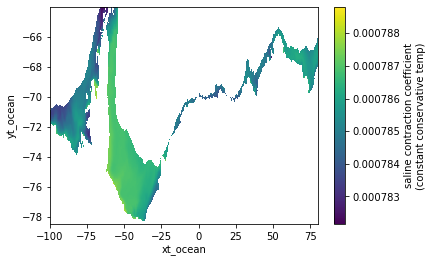

In [12]:
haline_contraction.mean('time').plot()

In [19]:
# Density binning sigma0:

# Alter if density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
# sigma1:
#isopycnal_bins = np.arange(32.25, 32.75, 0.01) 
# sigma0:
#isopycnal_bins = np.arange(27.5, 28.1, 0.04)
# fine bins just for DSW:
isopycnal_bins = np.arange(27.7, 28.1, 0.02)

bin_bottoms = isopycnal_bins[:-1]

binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'salt transformation in isopycnal bins summed over time')
binned_salt_transformation.chunk({'isopycnal_bins':1})

binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'heat transformation in isopycnal bins summed over time')
binned_heat_transformation.chunk({'isopycnal_bins':1})

for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    salt_transformation_tmp = salt_transformation.sel(time=slice(start_t, end_t))
    heat_transformation_tmp = heat_transformation.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))
                                                      
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_0_tmp.where(pot_rho_0_tmp <= isopycnal_bins[i+1]).where(pot_rho_0_tmp > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i,tt,:,:] = masked_transform

        masked_transform = (heat_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i,tt,:,:] = masked_transform
    print('Year %i done'%time_yearly[tt])

Year 2150 done
Year 2151 done
Year 2152 done
Year 2153 done
Year 2154 done
Year 2155 done
Year 2156 done
Year 2157 done
Year 2158 done
Year 2159 done


In [20]:
# calculate transformation sigma0:

c_p = 3992.1
isopycnal_bin_diff  = np.diff(isopycnal_bins)
isopycnal_bin_mid   = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

# Will be overwritten in loop, this is just to get the dimensions etc
salt_transformation_sigma0 = binned_salt_transformation
heat_transformation_sigma0 = binned_heat_transformation

salt_transformation_tmp = binned_salt_transformation / 365.
heat_transformation_tmp = binned_heat_transformation / c_p / 365.

# This procedure defines fluxes from lighter to denser classes as negative, we want the opposite
salt_transformation_sigma0 = -1*salt_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]
heat_transformation_sigma0 = -1*heat_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]

# Convert the binned (and summed through time) salt and heat transformation DataArrays to Datasets (to save metadata) and save to netCDF
#ds = xr.Dataset({'binned_salt_transformation': salt_transformation})
#ds = xr.Dataset({'binned_heat_transformation': heat_transformation})

#############################################################
net_transformation_control = heat_transformation_sigma0 + salt_transformation_sigma0
#############################################################

# Rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
net_transformation_control.coords['isopycnal_bins'] = isopycnal_bin_mid
ds = xr.Dataset({'net_transformation_control': net_transformation_control})
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/'+region+'_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
ds.to_netcdf(outpath)

## Up perturbation:

In [10]:
# conservative temperature
SST = cc.querying.getvar(easterlies_up, 'surface_temp', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) - 273.15
SST = SST.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Practical salinity, need to convert to absolute salinity
SSS_PSU = cc.querying.getvar(easterlies_up, 'surface_salt', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
SSS_PSU = SSS_PSU.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Unfortunately net_sfc_heating diagnostic is incorrect/missing for these runs:
#net_sfc_heating = cc.querying.getvar(easterlies_up, 'net_sfc_heating', easterlies_session, start_time=start_time, end_time=end_time)
#net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
net_sfc_heating = cc.querying.getvar(easterlies_up, 'sfc_hflux_from_runoff', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up, 'sfc_hflux_coupler', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up, 'sfc_hflux_pme', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up, 'frazil_3d_int_z', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc')
net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Mass flux of precipitation - evaporation + river runoff
pme_river = cc.querying.getvar(easterlies_up, 'pme_river', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
pme_river = pme_river.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Salt flux from ice and restoring:
salt_flux = cc.querying.getvar(easterlies_up, 'sfc_salt_flux_ice', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) + \
            cc.querying.getvar(easterlies_up, 'sfc_salt_flux_restore', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
salt_flux = salt_flux.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Surface density:
pot_rho_0 = cc.querying.getvar(easterlies_up, 'pot_rho_0', easterlies_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=0,method='nearest')

In [11]:
time_monthly = SST.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(control,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+ n_years, 1).astype('int')

In [12]:
# limit to continental shelf region:
SST  = shelf_mask_isobath(SST)[0]
SSS_PSU = shelf_mask_isobath(SSS_PSU)[0]
pot_rho_0 = shelf_mask_isobath(pot_rho_0)[0]
net_sfc_heating = shelf_mask_isobath(net_sfc_heating)[0]
pme_river = shelf_mask_isobath(pme_river)[0]
salt_flux = shelf_mask_isobath(salt_flux)[0]

In [13]:
# convert to absolute salinity:
# convert units to absolute salinity 
SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})

In [14]:
# Compute salt transformation (no density binning)
haline_contraction  = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
salt_transformation = haline_contraction * SSS * (pme_river - salt_flux) * n_days_array
salt_transformation = salt_transformation.load()

# Compute heat transformation (no density binning)
thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
heat_transformation = thermal_expansion * net_sfc_heating * n_days_array
heat_transformation = heat_transformation.load()

In [15]:
# Density binning sigma0:

# Alter if density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
# sigma1:
#isopycnal_bins = np.arange(32.25, 32.75, 0.01) 
# sigma0:
isopycnal_bins = np.arange(27.5, 28.1, 0.04)
# fine bins just for DSW:
isopycnal_bins = np.arange(27.7, 28.1, 0.02)

bin_bottoms = isopycnal_bins[:-1]

binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'salt transformation in isopycnal bins summed over time')
binned_salt_transformation.chunk({'isopycnal_bins':1})

binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'heat transformation in isopycnal bins summed over time')
binned_heat_transformation.chunk({'isopycnal_bins':1})

for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    salt_transformation_tmp = salt_transformation.sel(time=slice(start_t, end_t))
    heat_transformation_tmp = heat_transformation.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))
                                                      
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_0_tmp.where(pot_rho_0_tmp <= isopycnal_bins[i+1]).where(pot_rho_0_tmp > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i,tt,:,:] = masked_transform

        masked_transform = (heat_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i,tt,:,:] = masked_transform
    print('Year %i done'%time_yearly[tt])

Year 2150 done
Year 2151 done
Year 2152 done
Year 2153 done
Year 2154 done
Year 2155 done
Year 2156 done
Year 2157 done
Year 2158 done
Year 2159 done


In [16]:
# calculate transformation sigma0:

c_p = 3992.1
isopycnal_bin_diff  = np.diff(isopycnal_bins)
isopycnal_bin_mid   = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

# Will be overwritten in loop, this is just to get the dimensions etc
salt_transformation_sigma0 = binned_salt_transformation
heat_transformation_sigma0 = binned_heat_transformation

salt_transformation_tmp = binned_salt_transformation / 365.
heat_transformation_tmp = binned_heat_transformation / c_p / 365.

# This procedure defines fluxes from lighter to denser classes as negative, we want the opposite
salt_transformation_sigma0 = -1*salt_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]
heat_transformation_sigma0 = -1*heat_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]

#############################################################
net_transformation_up1 = heat_transformation_sigma0 + salt_transformation_sigma0
#############################################################

# Rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
net_transformation_up1.coords['isopycnal_bins'] = isopycnal_bin_mid
ds = xr.Dataset({'net_transformation_up1': net_transformation_up1})
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/'+region+'_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
ds.to_netcdf(outpath)

## Up noDSW perturbation:

In [17]:
# conservative temperature
SST = cc.querying.getvar(easterlies_up_noDSW, 'surface_temp', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) - 273.15
SST = SST.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Practical salinity, need to convert to absolute salinity
SSS_PSU = cc.querying.getvar(easterlies_up_noDSW, 'surface_salt', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
SSS_PSU = SSS_PSU.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Unfortunately net_sfc_heating diagnostic is incorrect/missing for these runs:
#net_sfc_heating = cc.querying.getvar(easterlies_up_noDSW, 'net_sfc_heating', easterlies_session, start_time=start_time, end_time=end_time)
#net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
net_sfc_heating = cc.querying.getvar(easterlies_up_noDSW, 'sfc_hflux_from_runoff', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up_noDSW, 'sfc_hflux_coupler', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up_noDSW, 'sfc_hflux_pme', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up_noDSW, 'frazil_3d_int_z', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc')
net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Mass flux of precipitation - evaporation + river runoff
pme_river = cc.querying.getvar(easterlies_up_noDSW, 'pme_river', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
pme_river = pme_river.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Salt flux from ice and restoring:
salt_flux = cc.querying.getvar(easterlies_up_noDSW, 'sfc_salt_flux_ice', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) + \
            cc.querying.getvar(easterlies_up_noDSW, 'sfc_salt_flux_restore', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
salt_flux = salt_flux.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Surface density:
pot_rho_0 = cc.querying.getvar(easterlies_up_noDSW, 'pot_rho_0', easterlies_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=0,method='nearest')

In [18]:
time_monthly = SST.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(control,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+ n_years, 1).astype('int')

In [19]:
# limit to continental shelf region:
SST  = shelf_mask_isobath(SST)[0]
SSS_PSU = shelf_mask_isobath(SSS_PSU)[0]
pot_rho_0 = shelf_mask_isobath(pot_rho_0)[0]
net_sfc_heating = shelf_mask_isobath(net_sfc_heating)[0]
pme_river = shelf_mask_isobath(pme_river)[0]
salt_flux = shelf_mask_isobath(salt_flux)[0]

In [20]:
# convert to absolute salinity:
# convert units to absolute salinity 
SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})

In [21]:
# Compute salt transformation (no density binning)
haline_contraction  = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
salt_transformation = haline_contraction * SSS * (pme_river - salt_flux) * n_days_array
salt_transformation = salt_transformation.load()

# Compute heat transformation (no density binning)
thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
heat_transformation = thermal_expansion * net_sfc_heating * n_days_array
heat_transformation = heat_transformation.load()

In [ ]:
# Density binning sigma0:

# Alter if density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
# sigma1:
#isopycnal_bins = np.arange(32.25, 32.75, 0.01) 
# sigma0:
isopycnal_bins = np.arange(27.5, 28.1, 0.04)
# fine bins just for DSW:
isopycnal_bins = np.arange(27.7, 28.1, 0.02)

bin_bottoms = isopycnal_bins[:-1]

binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'salt transformation in isopycnal bins summed over time')
binned_salt_transformation.chunk({'isopycnal_bins':1})

binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'heat transformation in isopycnal bins summed over time')
binned_heat_transformation.chunk({'isopycnal_bins':1})

for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    salt_transformation_tmp = salt_transformation.sel(time=slice(start_t, end_t))
    heat_transformation_tmp = heat_transformation.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))
                                                      
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_0_tmp.where(pot_rho_0_tmp <= isopycnal_bins[i+1]).where(pot_rho_0_tmp > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i,tt,:,:] = masked_transform

        masked_transform = (heat_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i,tt,:,:] = masked_transform
    print('Year %i done'%time_yearly[tt])

Year 2150 done
Year 2151 done
Year 2152 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Year 2153 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Year 2154 done


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Year 2155 done


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [ ]:
# calculate transformation sigma0:

c_p = 3992.1
isopycnal_bin_diff  = np.diff(isopycnal_bins)
isopycnal_bin_mid   = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

# Will be overwritten in loop, this is just to get the dimensions etc
salt_transformation_sigma0 = binned_salt_transformation
heat_transformation_sigma0 = binned_heat_transformation

salt_transformation_tmp = binned_salt_transformation / 365.
heat_transformation_tmp = binned_heat_transformation / c_p / 365.

# This procedure defines fluxes from lighter to denser classes as negative, we want the opposite
salt_transformation_sigma0 = -1*salt_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]
heat_transformation_sigma0 = -1*heat_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]

#############################################################
net_transformation_up1 = heat_transformation_sigma0 + salt_transformation_sigma0
#############################################################

# Rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
net_transformation_up1.coords['isopycnal_bins'] = isopycnal_bin_mid
ds = xr.Dataset({'net_transformation_up1': net_transformation_up1})
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/'+region+'_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
ds.to_netcdf(outpath)

## Down perturbation:

In [ ]:
# conservative temperature
SST = cc.querying.getvar(easterlies_down, 'surface_temp', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) - 273.15
SST = SST.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Practical salinity, need to convert to absolute salinity
SSS_PSU = cc.querying.getvar(easterlies_down, 'surface_salt', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
SSS_PSU = SSS_PSU.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Unfortunately net_sfc_heating diagnostic is incorrect/missing for these runs:
#net_sfc_heating = cc.querying.getvar(easterlies_down, 'net_sfc_heating', easterlies_session, start_time=start_time, end_time=end_time)
#net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
net_sfc_heating = cc.querying.getvar(easterlies_down, 'sfc_hflux_from_runoff', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_down, 'sfc_hflux_coupler', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_down, 'sfc_hflux_pme', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_down, 'frazil_3d_int_z', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc')
net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Mass flux of precipitation - evaporation + river runoff
pme_river = cc.querying.getvar(easterlies_down, 'pme_river', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
pme_river = pme_river.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Salt flux from ice and restoring:
salt_flux = cc.querying.getvar(easterlies_down, 'sfc_salt_flux_ice', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) + \
            cc.querying.getvar(easterlies_down, 'sfc_salt_flux_restore', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
salt_flux = salt_flux.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Surface density:
pot_rho_0 = cc.querying.getvar(easterlies_down, 'pot_rho_0', easterlies_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=0,method='nearest')

In [ ]:
time_monthly = SST.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(control,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+ n_years, 1).astype('int')

In [ ]:
# limit to continental shelf region:
SST  = shelf_mask_isobath(SST)[0]
SSS_PSU = shelf_mask_isobath(SSS_PSU)[0]
pot_rho_0 = shelf_mask_isobath(pot_rho_0)[0]
net_sfc_heating = shelf_mask_isobath(net_sfc_heating)[0]
pme_river = shelf_mask_isobath(pme_river)[0]
salt_flux = shelf_mask_isobath(salt_flux)[0]

In [ ]:
# convert to absolute salinity:
# convert units to absolute salinity 
SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})

In [ ]:
# Compute salt transformation (no density binning)
haline_contraction  = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
salt_transformation = haline_contraction * SSS * (pme_river - salt_flux) * n_days_array
salt_transformation = salt_transformation.load()

# Compute heat transformation (no density binning)
thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
heat_transformation = thermal_expansion * net_sfc_heating * n_days_array
heat_transformation = heat_transformation.load()

In [ ]:
# Density binning sigma0:

# Alter if density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
# sigma1:
#isopycnal_bins = np.arange(32.25, 32.75, 0.01) 
# sigma0:
isopycnal_bins = np.arange(27.5, 28.1, 0.04)
# fine bins just for DSW:
isopycnal_bins = np.arange(27.7, 28.1, 0.02)

bin_bottoms = isopycnal_bins[:-1]

binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'salt transformation in isopycnal bins summed over time')
binned_salt_transformation.chunk({'isopycnal_bins':1})

binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'heat transformation in isopycnal bins summed over time')
binned_heat_transformation.chunk({'isopycnal_bins':1})

for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    salt_transformation_tmp = salt_transformation.sel(time=slice(start_t, end_t))
    heat_transformation_tmp = heat_transformation.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))
                                                      
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_0_tmp.where(pot_rho_0_tmp <= isopycnal_bins[i+1]).where(pot_rho_0_tmp > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i,tt,:,:] = masked_transform

        masked_transform = (heat_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i,tt,:,:] = masked_transform
    print('Year %i done'%time_yearly[tt])

In [ ]:
# calculate transformation sigma0:

c_p = 3992.1
isopycnal_bin_diff  = np.diff(isopycnal_bins)
isopycnal_bin_mid   = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

# Will be overwritten in loop, this is just to get the dimensions etc
salt_transformation_sigma0 = binned_salt_transformation
heat_transformation_sigma0 = binned_heat_transformation

salt_transformation_tmp = binned_salt_transformation / 365.
heat_transformation_tmp = binned_heat_transformation / c_p / 365.

# This procedure defines fluxes from lighter to denser classes as negative, we want the opposite
salt_transformation_sigma0 = -1*salt_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]
heat_transformation_sigma0 = -1*heat_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]

#############################################################
net_transformation_up1 = heat_transformation_sigma0 + salt_transformation_sigma0
#############################################################

# Rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
net_transformation_up1.coords['isopycnal_bins'] = isopycnal_bin_mid
ds = xr.Dataset({'net_transformation_up1': net_transformation_up1})
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/'+region+'_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
ds.to_netcdf(outpath)

## Up zonal perturbation:

In [19]:
# conservative temperature
SST = cc.querying.getvar(easterlies_up_zonal, 'surface_temp', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) - 273.15
SST = SST.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Practical salinity, need to convert to absolute salinity
SSS_PSU = cc.querying.getvar(easterlies_up_zonal, 'surface_salt', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
SSS_PSU = SSS_PSU.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Unfortunately net_sfc_heating diagnostic is incorrect/missing for these runs:
#net_sfc_heating = cc.querying.getvar(easterlies_up, 'net_sfc_heating', easterlies_session, start_time=start_time, end_time=end_time)
#net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
net_sfc_heating = cc.querying.getvar(easterlies_up_zonal, 'sfc_hflux_from_runoff', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up_zonal, 'sfc_hflux_coupler', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up_zonal, 'sfc_hflux_pme', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up_zonal, 'frazil_3d_int_z', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc')
net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Mass flux of precipitation - evaporation + river runoff
pme_river = cc.querying.getvar(easterlies_up_zonal, 'pme_river', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
pme_river = pme_river.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Salt flux from ice and restoring:
salt_flux = cc.querying.getvar(easterlies_up_zonal, 'sfc_salt_flux_ice', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) + \
            cc.querying.getvar(easterlies_up_zonal, 'sfc_salt_flux_restore', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
salt_flux = salt_flux.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Surface density:
pot_rho_0 = cc.querying.getvar(easterlies_up_zonal, 'pot_rho_0', easterlies_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=0,method='nearest')

# Coordinates
lon_t = cc.querying.getvar(control,'geolon_t',master_session, n=1)
lon_t = lon_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
lat_t = cc.querying.getvar(control,'geolat_t',master_session, n=1)
lat_t = lat_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [20]:
# Extract coordinate arrays:
yt_ocean = SST.yt_ocean.values
xt_ocean = SST.xt_ocean.values
time_monthly = SST.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(control,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+len(SST.time)/12, 1).astype('int')
n_years = len(time_yearly)

In [21]:
# limit to continental shelf region:
SST  = shelf_mask_isobath(SST)[0]
SSS_PSU = shelf_mask_isobath(SSS_PSU)[0]
pot_rho_0 = shelf_mask_isobath(pot_rho_0)[0]
net_sfc_heating = shelf_mask_isobath(net_sfc_heating)[0]
pme_river = shelf_mask_isobath(pme_river)[0]
salt_flux = shelf_mask_isobath(salt_flux)[0]
lon_t   = shelf_mask_isobath(lon_t)[0]
lat_t   = shelf_mask_isobath(lat_t)[0]

In [22]:
# convert to absolute salinity:

st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1)
depth = st_ocean[0].values
depth_tile = (lat_t*0+1)*depth
pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    
# convert units to absolute salinity 
SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], 
                   name = 'sea surface salinity', 
                   attrs = {'units':'Absolute Salinity (g/kg)'})

In [23]:
# Compute salt transformation (no density binning)
haline_contraction  = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
salt_transformation = haline_contraction * SSS * (pme_river - salt_flux) * n_days_array
salt_transformation = salt_transformation.load()

# Compute heat transformation (no density binning)
thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
heat_transformation = thermal_expansion * net_sfc_heating * n_days_array
heat_transformation = heat_transformation.load()

In [24]:
# Density binning sigma0:

# Alter if density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
# sigma1:
#isopycnal_bins = np.arange(32.25, 32.75, 0.01) 
# sigma0:
isopycnal_bins = np.arange(27.5, 28.1, 0.04)

bin_bottoms = isopycnal_bins[:-1]

binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'salt transformation in isopycnal bins summed over time')
binned_salt_transformation.chunk({'isopycnal_bins':1})

binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'heat transformation in isopycnal bins summed over time')
binned_heat_transformation.chunk({'isopycnal_bins':1})

for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    salt_transformation_tmp = salt_transformation.sel(time=slice(start_t, end_t))
    heat_transformation_tmp = heat_transformation.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))
                                                      
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_0_tmp.where(pot_rho_0_tmp <= isopycnal_bins[i+1]).where(pot_rho_0_tmp > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i,tt,:,:] = masked_transform

        masked_transform = (heat_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i,tt,:,:] = masked_transform
    print('Year %i done'%time_yearly[tt])

Year 2150 done
Year 2151 done
Year 2152 done
Year 2153 done
Year 2154 done
Year 2155 done
Year 2156 done
Year 2157 done
Year 2158 done
Year 2159 done


In [25]:
# calculate transformation sigma0:

c_p = 3992.1
isopycnal_bin_diff  = np.diff(isopycnal_bins)
isopycnal_bin_mid   = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

# Will be overwritten in loop, this is just to get the dimensions etc
salt_transformation_sigma0 = binned_salt_transformation
heat_transformation_sigma0 = binned_heat_transformation

salt_transformation_tmp = binned_salt_transformation / 365.
heat_transformation_tmp = binned_heat_transformation / c_p / 365.

# This procedure defines fluxes from lighter to denser classes as negative, we want the opposite
salt_transformation_sigma0 = -1*salt_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]
heat_transformation_sigma0 = -1*heat_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]

#############################################################
net_transformation_up1 = heat_transformation_sigma0 + salt_transformation_sigma0
#############################################################

# Rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
net_transformation_up1.coords['isopycnal_bins'] = isopycnal_bin_mid
ds = xr.Dataset({'net_transformation_up1': net_transformation_up1})
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_zonal+'/SWMT/'+region+'_shelf_transformation_sigma0_'+time_period+'.nc'
ds.to_netcdf(outpath)

## Up meridional perturbation:

In [26]:
# conservative temperature
SST = cc.querying.getvar(easterlies_up_meridional, 'surface_temp', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) - 273.15
SST = SST.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Practical salinity, need to convert to absolute salinity
SSS_PSU = cc.querying.getvar(easterlies_up_meridional, 'surface_salt', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
SSS_PSU = SSS_PSU.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Unfortunately net_sfc_heating diagnostic is incorrect/missing for these runs:
#net_sfc_heating = cc.querying.getvar(easterlies_up, 'net_sfc_heating', easterlies_session, start_time=start_time, end_time=end_time)
#net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
net_sfc_heating = cc.querying.getvar(easterlies_up_meridional, 'sfc_hflux_from_runoff', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up_meridional, 'sfc_hflux_coupler', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up_meridional, 'sfc_hflux_pme', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc') +\
                    cc.querying.getvar(easterlies_up_meridional, 'frazil_3d_int_z', easterlies_session, start_time=start_time, end_time=end_time,ncfile='ocean_month.nc')
net_sfc_heating = net_sfc_heating.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Mass flux of precipitation - evaporation + river runoff
pme_river = cc.querying.getvar(easterlies_up_meridional, 'pme_river', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
pme_river = pme_river.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Salt flux from ice and restoring:
salt_flux = cc.querying.getvar(easterlies_up_meridional, 'sfc_salt_flux_ice', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time) + \
            cc.querying.getvar(easterlies_up_meridional, 'sfc_salt_flux_restore', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
salt_flux = salt_flux.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# Surface density:
pot_rho_0 = cc.querying.getvar(easterlies_up_meridional, 'pot_rho_0', easterlies_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=0,method='nearest')

In [27]:
time_monthly = SST.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(control,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+ n_years, 1).astype('int')

In [28]:
# limit to continental shelf region:
SST  = shelf_mask_isobath(SST)[0]
SSS_PSU = shelf_mask_isobath(SSS_PSU)[0]
pot_rho_0 = shelf_mask_isobath(pot_rho_0)[0]
net_sfc_heating = shelf_mask_isobath(net_sfc_heating)[0]
pme_river = shelf_mask_isobath(pme_river)[0]
salt_flux = shelf_mask_isobath(salt_flux)[0]

In [29]:
# convert to absolute salinity:
# convert units to absolute salinity 
SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})

In [30]:
# Compute salt transformation (no density binning)
haline_contraction  = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
salt_transformation = haline_contraction * SSS * (pme_river - salt_flux) * n_days_array
salt_transformation = salt_transformation.load()

# Compute heat transformation (no density binning)
thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
heat_transformation = thermal_expansion * net_sfc_heating * n_days_array
heat_transformation = heat_transformation.load()

In [31]:
# Density binning sigma0:

# Alter if density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
# sigma1:
#isopycnal_bins = np.arange(32.25, 32.75, 0.01) 
# sigma0:
isopycnal_bins = np.arange(27.5, 28.1, 0.04)

bin_bottoms = isopycnal_bins[:-1]

binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'salt transformation in isopycnal bins summed over time')
binned_salt_transformation.chunk({'isopycnal_bins':1})

binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, time_yearly, yt_ocean, xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'heat transformation in isopycnal bins summed over time')
binned_heat_transformation.chunk({'isopycnal_bins':1})

for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    salt_transformation_tmp = salt_transformation.sel(time=slice(start_t, end_t))
    heat_transformation_tmp = heat_transformation.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))
                                                      
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_0_tmp.where(pot_rho_0_tmp <= isopycnal_bins[i+1]).where(pot_rho_0_tmp > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i,tt,:,:] = masked_transform

        masked_transform = (heat_transformation_tmp * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i,tt,:,:] = masked_transform
    print('Year %i done'%time_yearly[tt])

Year 2150 done
Year 2151 done
Year 2152 done
Year 2153 done
Year 2154 done
Year 2155 done
Year 2156 done
Year 2157 done
Year 2158 done
Year 2159 done


In [32]:
# calculate transformation sigma0:

c_p = 3992.1
isopycnal_bin_diff  = np.diff(isopycnal_bins)
isopycnal_bin_mid   = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

# Will be overwritten in loop, this is just to get the dimensions etc
salt_transformation_sigma0 = binned_salt_transformation
heat_transformation_sigma0 = binned_heat_transformation

salt_transformation_tmp = binned_salt_transformation / 365.
heat_transformation_tmp = binned_heat_transformation / c_p / 365.

# This procedure defines fluxes from lighter to denser classes as negative, we want the opposite
salt_transformation_sigma0 = -1*salt_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]
heat_transformation_sigma0 = -1*heat_transformation_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]

#############################################################
net_transformation_up1 = heat_transformation_sigma0 + salt_transformation_sigma0
#############################################################

# Rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
net_transformation_up1.coords['isopycnal_bins'] = isopycnal_bin_mid
ds = xr.Dataset({'net_transformation_up1': net_transformation_up1})
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_meridional+'/SWMT/'+region+'_shelf_transformation_sigma0_'+time_period+'.nc'
ds.to_netcdf(outpath)